# Basics of mobile robotics, Project

Authors:

    -Matthieu Gachet
    -Rémi Tanguy Oddon
    -Aly Elbindary
    -Erik Mortensen


## Table of Contents

* [Introduction](#Introduction)
    * [Context Description](#Context)
    * [Porject Objectives](#Objectives)
    * [Chosen Environment](#Chosen_Environment) 
* [Vision](#Vision)
    * [Envisaged solutions](#Envisaged_solutions)
    * [Organigramme of vision functions 1.2](#Organigramme_of_vision_functions)
* [Filtering](#Filtering)
    * [Model](#Model)
    * [Determination of perturbation and noise matrices 2.2](#Determination)
    * [Filtering principle](#Filtering_principle)
* [Global navigation function](#Global)
* [Local navigation](#Local)
    * [Artificial Neural Network (ANN) : Working principle](#ANN)
    * [Local Avoidance of Local Obstacles](#Local_local)
    * [Local Avoidance of Global Obstacles : The "Seven Point" Method](#Global_seven)
    * [Wing Mirrors](#Wing)
    * [Summary of Local Navigation](#Summary_local)

* [Motion control functions](#Motion)
* [Code test](#Test_code)
* [Execution](#Execution)
    * [Thymio connection](#Thymio_connection)
    * [Camera connection](#Camera_connection)
    * [Color thresholds measuring](#Color)
    * [Path initialisation](#Path)
    * [Thymio control loop](#Loop)
* [Conclusion](#Conclusion)
* [References](#References)
    

## Introduction <a class="anchor" id="Introduction"></a>

### Context Description <a class="anchor" id="Context"></a>

The motivation behind this project is the following scenario :

"A driverless tractor needs to get from point A to point B, through an agricultural field. In this field, there may be massive ponds or buildings that can get in the way; this is where the use of an aerial drone equipped with a downward facing camera will be useful to detect these big obstacles and determine the quickest path for the tractor. Well, what about other small, temporary, non-detectable (by the drone that is) obstacles such as sheep? What would the tractor do in this case to avoid them? Obviously using its front proximity sensors and its wing mirrors! Finally, what if pesky clouds block the view of the drone? Since the tractor is equipped with a robust Kalman Filter, it can still manage to follow its predetermined path without the help of the camera. And there you go! A functional automated tractor that can get to its destination without any collisions."

### Project Objectives <a class="anchor" id="Objectives"></a>

The goal of the project is to create a particular setup for the Thymio robot, in which all five modules (Vision, Global Navigation, Motion Control, Filtering and Local Navigation) must be implemented and not only work individually, but be able to seemlessly transition from one state to another, and communicate between the different modules if needed.

### Chosen Environment <a class="anchor" id="Chosen Environment"></a>

The setup we have chosen for our project is a simple blank white canvas as the field, big global obstacles are represented as different 2D shapes in black, within the canvas, and different landmarks are used to indicate different parts of the setup, such as the Thymio position, the end point, etc. The detection and interpretation of these different elements by the camera will be more thoroughly explained within the "Vision" section. This is what we have as a fixed starting map, now as the Thymio robot navigates through the terrain, local obstacles will be randomly placed at any given moment and at any location, these local obstacles come in the shape of small 3D boxes, and will be used to test the local navigation module.
Another noteworthy aspect is a slight modification we have made to the thymio robot : two wing mirrors have been added to the side of the thymio robot in order to improve local navigation ; this shall be further explained in the "Local Navigation Section" 



## Vision <a class="anchor" id="Vision"></a>

### Envisaged solutions <a class="anchor" id="Envisaged_solutions"></a>

We thought about 3 possible ways to implement the vision:

1) The first idea was to only deal with white and black images. In this case, we used three types of circle landmarks and the **cv2.matchTemplate()** function to detect the goal and the robot position and orientation (see fig. below). This idea works fine and was robust to light change but had weak performances regarding to the orientation and the height of the camera.

<img src="Images/Rapport_image_vision_white_black.PNG" width="400">

2) To be more robust to those parameters we thought to use a QR code and dedicated functions made available by the OpenCV library. The reason we finally did not implement and test this solution was that we found it more interesting to develop our third solution.

3) This last idea was quite like the first one, except that we didn’t try to detect a specified form, but only a specified color. In our case we use green, red and blue landmarks (see fig. below). Thereby the orientation, and the size of each landmark does not have importance. The con of this method is that if the program detects more than one zone with the color we are looking for, it can’t say which one corresponds to a landmark. Consequently, if during the program's execution we lay a red or green obstacle on the map, the camera looses the position of the robot, hopefully, the filtering is here to deal with this problem during few moments.



<img src="Images/Rapport_image_vision_color.JPG" width="400">

### Chart of vision functions <a class="anchor" id="Chart_of_vision_functions"></a>

We can classify the vision functions in four groups:

First, we need functions to detect the landmarks. For this we use **inRange()** function to extract one color from the image, if there is only one occurrence of the color, we compute it’s position with **getPosColor(BRGimage, color, threshold)**  function. Finally we use **getPose(BRGimage, threshold)** and **getGoal(BRGimage, threshold)** to determine the robot pose and the goal position. If either the robot or the goal is not detected, we get negative value as position. (see Organigramme below) 

<img src="Images/Rapport_image_vision_code_positions.JPG" width="600">

Then we need to detect the obstacle. For this we apply a threshold on the image we desire to analyze. In particular we had to apply a mask on the goal to avoid detect it as an obstacle since its landmark is dark, this is done with function **GetObstacleForm(BRG/GrayImage, positionGoal)**. Then, with the function **GetCrossingPoint(BRG/GrayImage, positionGoal)** we can sample the contours and get a list of points which constitutes them.

<img src="Images/Rapport_image_vision_code_contour_detection.JPG" width="300">

After that, we need to compute all the possible path that the robot can take. For that, we have a function **isCrossingObs(point1, point1, imageObstacle)** which detects if two points can be reachable in straight line. Moreover, we have the function **getPossiblePath(posContouPoint, imageObs)** which returns a list of the form:

\[….., (point_i, [all points reachable from point_i]), …..\]

and the function **getPossiblePathByRobot(posContouPoint, posRobot, imageObs)** which returns a list of the form:

\[(posRobot, [all points reachable from posRobot])\].

The reason we have those two similar functions, is to avoid recalculating all the possible paths every time we must find the best path again (Kidnapping situation). Indeed, when the map becomes complex, it takes time to determine those paths.

<img src="Images/Rapport_image_vision_code_pp.JPG" width="300">

Finally, we also add to the vision library some function to add information to an image, see figure below.

<img src="Images/Rapport_image_vision_draw.JPG" width="1000">



It is possible to observe the effects of these functions as well in the "Path initialization section", by setting the global variable "TEST" to True.

## Filtering <a class="anchor" id="Filtering"></a>

In this section, we used an extended Kalman filter, which is an extension of the regular Kalman filter but for non-linear systems. We needed to determine a model of the Thymio's dynamic and also values for the standard deviations of the pertubation on the model predictions and noise applying on sensors. 

### Model <a class="anchor" id="Model"></a>

Regarding the model, we would like to know the Thymio's XY position and also its orientation w.r.t the X axis. We only have access to the left and right wheel speeds, but we can deduce the overall speed and rotation speed $v$ and $\omega$ thanks to the following representation (see figure below), giving $v=\frac{v_l+v_r}{2}$ and $\omega=\frac{v_l-v_r}{d}$, $d$ the distance between the wheels.

<img src="Images/Rapport_image_filtering_thymio_dynamic.png" width="900">

We know that $\begin{pmatrix}\dot{x}\\ \dot{y}\\ \dot{\alpha}\end{pmatrix}=\begin{pmatrix}v\cdot cos{(\alpha)}\\ v\cdot sin{(\alpha)} \\ \omega\end{pmatrix}$, therefore by approximating the integrals we may deduce the Thymio's states.

The sensors used to give the state measurements are the camera and the speed sensors located on the wheels. Because we are now sensing the speed on wheels, we need to add the overall velocity to the states, giving us the following state-space representation with the integration taken into account.

$$\begin{pmatrix}
x(k+1) \\ y(k+1) \\ \alpha(k+1) \\ v(k+1)
\end{pmatrix}=f(\vec{x},u) = \begin{pmatrix}
x(k)+T\cdot v(k)\cdot\cos{(\alpha(k))} \\ y(k)+T\cdot v(k)\cdot\sin{(\alpha(k))} \\ \alpha(k)+T\cdot\frac{v_l-v_r}{d} \\ \frac{v_l+v_r}{2}
\end{pmatrix}$$

For the extended Kalman filter framework, we need to linearize the dynamics around the operating point. The Jacobian of $f$ is computed here :

$$A=\frac{\partial f}{\partial x}(\vec{x},u)=\begin{pmatrix}
1 & 0 & -T\cdot v(k)\cdot\sin{(\alpha(k))} & T\cdot\cos{(\alpha(k))} \\
0 & 1 & T\cdot v(k)\cdot\cos{(\alpha(k))} & T\cdot\sin{(\alpha(k))} \\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 
\end{pmatrix}$$

### Determination of perturbation and noise matrices <a class="anchor" id="Determination"></a>

We now need to estimate the perturbations on the model and noise on sensors. We could have chosen a heuristic approach but decided instead to acquire some data about the Thymio's states while moving to estimate the desired standard deviations.

The Thymio followed a path and its XY position, orientation, speed on wheels (target speed and speed sensed) and the sampling time $T$ were stored. For each time step, based on the current states given by the camera, the model predicted the next states and it was compared with the next one given by the camera. Then, we can look at the difference between the reality and prediction. From this difference, the standard deviations for the errors on the model can be computed.

<img src="Images/Rapport_image_filtring_model_perturbations.png" width="1200">

The process to determine the noise on the sensors is similar, we set the Thymio at rest and monitor its states. We obtain the following variations across time for each state :

<img src="Images/Rapport_image_sensor_noises.png" width="1200">

Finally, we obtain the following matrix $Q$ for the model perturbations and matrix $R$ for the sensor noises : 
$$Q=\begin{pmatrix}
\sigma_{x}^{model} & 0 & 0 & 0 \\
0 & \sigma_{y}^{model} & 0 & 0 \\
0 & 0 & \sigma_{\alpha}^{model} & 0\\
0 & 0 & 0 & \sigma_{v}^{model} 
\end{pmatrix} = 
\begin{pmatrix}
1.754 & 0 & 0 & 0 \\
0 & 2.583 & 0 & 0 \\
0 & 0 & 0.037 & 0\\
0 & 0 & 0 & 0.028 
\end{pmatrix}$$

$$R=\begin{pmatrix}
\sigma_{x}^{sensor} & 0 & 0 & 0 \\
0 & \sigma_{y}^{sensor} & 0 & 0 \\
0 & 0 & \sigma_{\alpha}^{sensor} & 0\\
0 & 0 & 0 & \sigma_{v}^{sensor} 
\end{pmatrix} = 
\begin{pmatrix}
0.203 & 0 & 0 & 0 \\
0 & 0.742 & 0 & 0 \\
0 & 0 & 0.010 & 0\\
0 & 0 & 0 & 3.127
\end{pmatrix}$$

More details on the computation of the above standard deviations can be found in the filtering_parameters_determination folder.

### Filtering principle <a class="anchor" id="Filtering_principle"></a>

In the extended Kalman filter, we have 2 cases. In the first one, the camera detects where the Thymio is and transmits it. In the second scenario, the Thymio is not being found and therefore we must rely on the speed sensors to have a good states estimation. Therefore in the first case the observation matrix is $$C=\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}$$

and R is unchanged, whereas in the second case the observation matrix only uses the fourth state, namely the speed $v$, giving $C=\begin{pmatrix}0 & 0 & 0 & 1\end{pmatrix}$ and $R$ becomes $R=\begin{pmatrix}\sigma_{v}^{sensor}\end{pmatrix}=\begin{pmatrix}3.127\end{pmatrix}$ beause only speed is sensed.

More details on implementation for the Kalman filter can be found in filtering.py

## Global navigation <a class="anchor" id="Global"></a>

At the beginning of our project we had to choose between using the gradient method or the Dijkstra algorithm to perform the global navigation. To avoid the possibility of creating local minima that could block the robot, we decided to implement Dijkstra rather than gradient descent. 

The Dijkstra algorithm is a very efficient way to find the shortest path that connects two nodes in a map discretized by a number of nodes. Each node is linked to every other reachable node by a route. Each route is described by a weight depending on its length. This algorithm gives the shortest path between the origin and the objective nodes by finding the combination of routes that have the shortest weight.

The elaboration of the global navigation was straightforward since we only needed to write one function which implemented the Dijkstra algorithm. This function takes as input the robot position, the goal position and the list of possible paths, and returns a list of points that creates a path that leads to the objective.

The section [Path initialisation](#Path) shows the effect of this function by plotting the best path on a test image if the global variable "TEST" is set to True.

We can see how the Dijkstra algorithm works within our project by looking at the following two images:

![Pentagon](Images/dijkstra_pic.png)


The image on the left shows us the initial recorded canvas and the second image shows us all of the different paths generated by Dijkstra, with the nodes in blue, the possible paths in red,  and the shortest route in green.



## Local navigation <a class="anchor" id="Local"></a>

### Artificial Neural Network (ANN) : Working principle <a class="anchor" id="ANN"></a>

Amongst many different methods of local avoidance (such as potential fields, we have selected to go with an ANN : not only because it is an efficient method that takes advantage of the front infrared sensors of the Thymio Robot, but also because we needed to add an extra feature within our local avoidance : local avoidance of global obstacles. To show how ANNs easily allows us to add this feature, we first need to explain the working principle of an ANN.

An ANN is a system that takes in multiple inputs (x1, x2, ..., xn), passes them through a particular function (f(x)), which we call a neuron, and then at the end we get multiple outputs (y1, y2, ..., ym), with the number of inputs not necessarly equal to the number of neurons or the number of outputs. If the the input goes through multiple levels of neurons, we call this a multi-layered ANN.

The important part of an ANN are the weights, which are arbitrary values that we multiply with an input before it passes through a neuron ; these weights are key to the working principle of an ANN because they are manipulated by the user in order to obtain different values for the associated outputs, and thus achieve different results.

Here is a diagram showing an example of a double-layered ANN with three neurons, one input and one output. [2]

<br/>

![Pentagon](Images/double_layer_neuron.png)

<br/>

The ANN that we have decided to use for our porject is a single-layered ANN with the following characteristics : <br>
    - Twelve inputs : the five front infrared sensors and the seven points ; <br>
    - Two neurons ; <br>
    - Two outputs : the new values to give to the right and left motors. <br>
    
Therefore, there are 24 different weights needed for this particular ANN.
    
### Local Avoidance of Local Obstacles <a class="anchor" id="Local_local"></a>

The local obstacles differ from the global obstacle as they are 3D objects of bright color. They can be of any shape, placed anywhere at any time. The fact that they are in volume makes them detectable by the proximity sensors of the thymio. In this project, we only use the five proximity sensors located on the front of the robot.
When an object is detected by one of these sensors, the program switches to state 2 which is local avoidance. In this state, the speed of the wheels is impacted by the output of the neural network. This way, the robot adjusts immediately its orientation and velocity to avoid the detected obstacles in a fluid way.

### Local Avoidance of Global Obstacles : The "Seven-Point" Method <a class="anchor" id="Global_seven"></a>

Before going into explaining the "Seven-Point" method, we first need to explain why we need it. When the robot is in local avoidance, if the local obstacle happens to have appeared near a global obstacle, then it is possible that the robot can go into the global obstacle, since the these obstacles cannot be detected by the sensors due to their 2D shape. We thus need an extra feature in order to avoid this from happening, hence why we created the "Seven-Point" method.

The way the "Seven-Point" method works is that seven virtual points are created in front of the thymio robot. Their coordinates are collected and we then go through the array containing the pixels luminosity values and their coordinates. Finally, we check the luminosity of the pixels that have the same coordinates as the seven points. If the light intensity is equal to 255, that means that the pixel is white and thus does not correspond to a global obstacle, whereas if the intensity is equal to 0, then the pixel is black and thus the corresponding point is located within a global obstacle. In the latter scenario, this implies that the Thymio robot is heading towards a global obstacle because of the local avoidance, and thus the weights need to be adjusted in order to compensate for this behavior. In our case, if the point is within a global obstacle, then the associated weight will be a nonzero value, if not then it will be equal to 0, meaning the point will not have an impact as an input on the Thymio's movement. The following image shows the seven generated points for a particular radius: 

<br/>

![Pentagon](Images/SevenPoints.png)

<br/>

For this specific example, none of the points are within a global obstacle, thus all of the associated weights will be equal to 0.

### Wing Mirrors <a class="anchor" id="Wing"></a>

When the robot detects an obstacle with the lateral sensors, it switches to the local navigation state 
The biggest challenge with local navigation is to know when to exit this state to go back to the global navigation state.
If the thymio exits the local navigation too early, it will recalculate the global path without taking into account the local obstacle it was trying to avoid previously.
This situation will create oscillations in the robot's trajectory as it will frequently switch states between local and global navigation and thus reduce the efficiency of the whole navigation process.
On the other hand if the thymio exits the local navigation too late, as for example if we impose a minimal time period where it stays in this state, the thymio might go too far from the original path and lose time.
The goal would then be to be able to follow the obstacle without oscillating.

To achieve this goal, the solution we found is to reorient the beam of the lateral sensors with mirrors to be able to detect if there is an obstacle on the side of the thymio. The position of the mirrors is shown in the folllowing picture :

![Pentagon](Images/thymio_mirrors.jpg)


The robot is thus able to progress along the obstacle without exiting local navigation until the obstacle is totally out of sight.
This feature reduces the oscillatory behavior and thus increases the efficiency of the thymio.


### Summary of Local Navigation <a class="anchor" id="Summary_local"></a>

To conclude, using ANNs for our project has been extremely beneficial, since we were able to easily adapt the base method that we studied during the lectures in order for it to fit our needs within this specific project (being able to add the seven points as inputs to the ANN). The following diagram gives us a brief summary of how our ANN works.

![Pentagon](Images/ANN2.png)

For each link between an input x_i and the first neuron f1, there exists a corresponding weight w_l_i, as well as for every link between an input and the second neuron, there exists a corresponding weight w_r_i ; we thus have 24 weights. By manipulating these weights multiple times, we were able to obtain these following values :



In [1]:
#Weight for the neural network
w_l = [80,  100, -15, -100, -80, 0,0, -5,-15,  -7, -5, 7, 15, 5]
w_r = [-80, -100, -15,  100,  80, 0,0, 5, 15, 7, -5,  -7,  -15, -5]

For these values, we were able to achieve the most adequate values for y1 and y2, and thus the best Thymio behaviour when it comes to local navigation.

## Motion control functions <a class="anchor" id="Motion"></a>

The motion control of the robot is based on a proportional controller on the angular error. Since the robot does not move fast and we don’t want to reach high precision, we have only an on/off controller on the mean speed.

More precisely the controller computes the angular speed difference of the two motors with a proportional behavior and bounds this difference to 200 \[Thymio units\]. The mean velocity is set to 100\[Thymio units\] when the |angular error| is below 3*pi/4 (or pi/4 if the previous error was 3*pi/4) and to 0 otherwise. The figure below shown this behavior. 

<img src="Images\Rapport_image_motion_control.JPG" width="700">

The role of the hysteresis is to keep the robot turning on itself when the error is big. This case appends often in case of kidnapping or when the robot switches from local navigation to global navigation. If we do not implement this behaviour, the robot follows a circular arc trajectory and could hit global or local obstacles.

## Necessary import

In [17]:
# import the libraries
import cv2
import matplotlib.pyplot as plt  
import time
import numpy as np
import math
import copy
from scipy import signal
from scipy.spatial import distance
import statistics 
import filtering
import vision 
import local_nav 
import global_nav
import motion

## Code use to test the set up <a class="anchor" id="Test_code"></a>

In [18]:
TEST = True

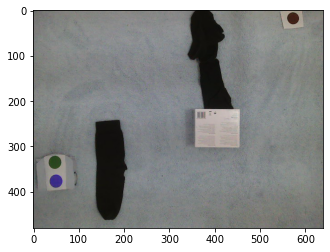

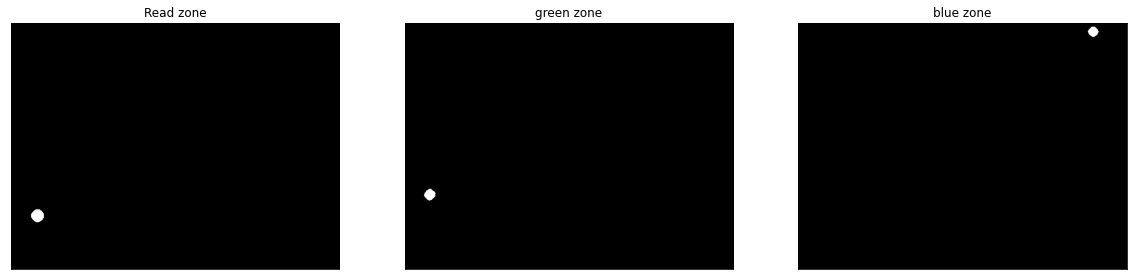

In [19]:
if not TEST:
    ret, frame = vid.read() 
else:
    frame = cv2.imread("../Images/Atest4.PNG")
    thresholdColor = vision.THRESHOLD_COLOR 

vision.testColor(frame, thresholdColor)

## Execution <a class="anchor" id="Execution"></a>

The followings cells are those we need to run to make the robot works.  

-First, we need to connect the Thymio and the camera. 

-Then a piece of code allows us to measure the threshold value we need to detect color

-After that we compute and display the best path for the robot.

-Finally, a loop controls the robot and determine in which case it is. This loop can be described by the following finite state machine.  

<img src="Images/Rapport_image_FSM.JPG" width="900">

### Thymio connection <a class="anchor" id="Thymio_connection"></a>

In [3]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()

In [4]:
await node.lock()

Node 20c63a38-a097-450b-b083-fef22919dbd5

### Camera connection <a class="anchor" id="Camera_connection"></a>

In [9]:
vid = cv2.VideoCapture(0)
for i in range(10000):
    ret, frame = vid.read() 
 
    cv2.imshow('frame', frame)
   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
      
# Destroy all the windows
cv2.destroyAllWindows()

### Color thresholds measuring <a class="anchor" id="Color"></a>

The code below allows to measure the best range to detect red, green and blue. To do it, we must lay side by side the three landmarks on the map, then we run this code. We can select the zone where are the marks, then select each color zone with the mouse left button. (We must respect the following order: red -> green -> blue, and always select the upper left corner, then the lower right one).
The code computes the mean and standard deviation for each HSV component of each color and deduce the range of each color.

This code can be tested without the camera if the global variable "TEST" is set to True.

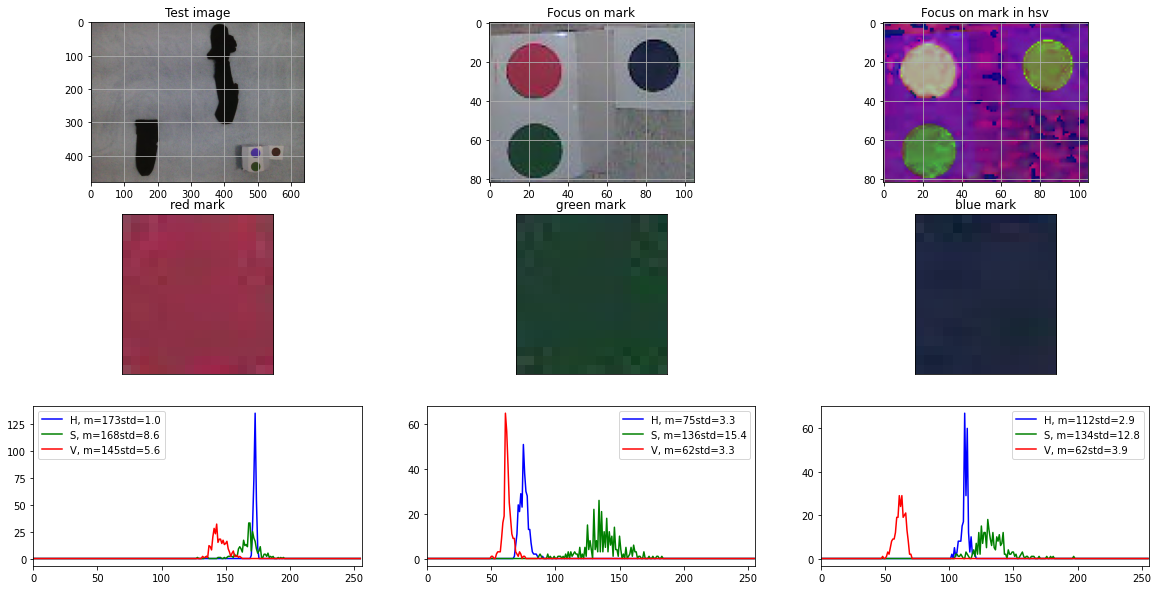

In [21]:
if not TEST:
    ret, frame = vid.read() 
else:
    frame = cv2.imread("../Images/Atest5.PNG")
    thresholdColor = vision.THRESHOLD_COLOR 

SCALE_FACTOR = 10
FACTOR_H = 3 # Lower H composant = mean H composant - FACTOR_H*std_H_composant
FACTOR_S = 10 # Lower S composant = mean S composant - FACTOR_S std_S composant
FACTOR_V = 10 # Lower V composant = mean V composant - FACTOR_V std V composant


imageTest = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


def onMouse(event, x, y, flags, param):
    global posList
    if event == cv2.EVENT_LBUTTONDOWN:
        posList.append([x, y])


posList = []
cv2.namedWindow("Test_image")
cv2.setMouseCallback('Test_image', onMouse)
posNp = np.array(posList)
while(1):
    cv2.imshow('Test_image',frame)
    if cv2.waitKey(1) & (0xFF == ord('q') or len(posList)==2):
        break
cv2.destroyAllWindows()

focus = imageTest[posList[0][1]:posList[1][1],posList[0][0]:posList[1][0]]
hsv = cv2.cvtColor(focus, cv2.COLOR_RGB2HSV)
focusS = cv2.resize(focus, None, fx=SCALE_FACTOR, fy = SCALE_FACTOR, interpolation = cv2.INTER_LINEAR)

posList = []
cv2.namedWindow("Focus_image")
cv2.setMouseCallback('Focus_image', onMouse)
posNp = np.array(posList)
while(1):
    cv2.imshow('Focus_image',cv2.cvtColor(focusS, cv2.COLOR_BGR2RGB))
    if cv2.waitKey(1) & (0xFF == ord('q') or len(posList)==6):
        break
cv2.destroyAllWindows()

posList = [[int(el[0]/SCALE_FACTOR), int(el[1]/SCALE_FACTOR)] for el in posList]



rr = hsv[posList[0][1]:posList[1][1],posList[0][0]:posList[1][0]]
rv = hsv[posList[2][1]:posList[3][1],posList[2][0]:posList[3][0]]
rb = hsv[posList[4][1]:posList[5][1],posList[4][0]:posList[5][0]]


fig = plt.figure(figsize = (20, 10))
plt.subplot(331),plt.imshow(frame)
plt.title('Test image'), plt.grid()
plt.subplot(332),plt.imshow(focus)
plt.title('Focus on mark'),plt.grid()
plt.subplot(333),plt.imshow(hsv)
plt.title('Focus on mark in hsv'),plt.grid()
plt.subplot(334),plt.imshow(cv2.cvtColor(rr, cv2.COLOR_HSV2RGB), cmap = 'gray')
plt.title('red mark'), plt.xticks([]), plt.yticks([])
plt.subplot(335),plt.imshow(cv2.cvtColor(rv, cv2.COLOR_HSV2RGB),cmap = 'gray')
plt.title('green mark'), plt.xticks([]), plt.yticks([])
plt.subplot(336),plt.imshow(cv2.cvtColor(rb, cv2.COLOR_HSV2RGB),cmap = 'gray')
plt.title('blue mark'), plt.xticks([]), plt.yticks([])

plt.subplot(337)

color = ('b','g','r')
for j,col in enumerate(color):
    histr = cv2.calcHist([rr],[j],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

HrM=np.mean(rr[:,:,0])
for i in range(len(rr)):
    for j in range(len(rr[i])):
        if rr[i][j][0] < 10:
            rr[i][j][0] = HrM
HrM=np.mean(rr[:,:,0])
HrStd=np.std(rr[:,:,0])
SrM=np.mean(rr[:,:,1])
SrStd=np.std(rr[:,:,1])
VrM=np.mean(rr[:,:,2])
VrStd=np.std(rr[:,:,2])

plt.legend(['H, m='+str(round(HrM)) +'std='+str(round(HrStd,1)), 'S, m='+str(round(SrM)) +'std='+str(round(SrStd,1)), 'V, m='+str(round(VrM)) +'std='+str(round(VrStd,1))])

plt.subplot(338)
color = ('b','g','r')
for j,col in enumerate(color):
    histr = cv2.calcHist([rv],[j],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

HvM=np.mean(rv[:,:,0])
HvStd=np.std(rv[:,:,0])
SvM=np.mean(rv[:,:,1])
SvStd=np.std(rv[:,:,1])
VvM=np.mean(rv[:,:,2])
VvStd=np.std(rv[:,:,2])

plt.legend(['H, m='+str(round(HvM)) +'std='+str(round(HvStd,1)), 'S, m='+str(round(SvM)) +'std='+str(round(SvStd,1)), 'V, m='+str(round(VvM)) +'std='+str(round(VvStd,1))])

plt.subplot(339)
color = ('b','g','r')
for j,col in enumerate(color):
    histr = cv2.calcHist([rb],[j],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

HbM=np.mean(rb[:,:,0])
HbStd=np.std(rb[:,:,0])
SbM=np.mean(rb[:,:,1])
SbStd=np.std(rb[:,:,1])
VbM=np.mean(rb[:,:,2])
VbStd=np.std(rb[:,:,2])

plt.legend(['H, m='+str(round(HbM)) +'std='+str(round(HbStd,1)), 'S, m='+str(round(SbM)) +'std='+str(round(SbStd,1)), 'V, m='+str(round(VbM)) +'std='+str(round(VbStd,1))])

plt.show()

# The best way to determine the range of it's color should be to determine center the range around the mean value
# of each composant, but the S and V composant are very  sensitive to the environement so finaly we do not use
# them to determine the range and just bound their values by default


LOWER_RED = [int(HrM-FACTOR_H*HrStd), 50, 50]
UPPER_RED = [int(HrM+FACTOR_H*HrStd), 255, 255]

LOWER_GREEN = [int(HvM-FACTOR_H*HvStd), 50, 30]
UPPER_GREEN = [int(HvM+FACTOR_H*HvStd), 255, 255]

LOWER_BLUE = [int(HbM-FACTOR_H*HbStd), 50, 30]
UPPER_BLUE = [int(HbM+FACTOR_H*HbStd), 255, 255]

thresholdColor = [LOWER_RED, UPPER_RED, LOWER_GREEN, UPPER_GREEN, LOWER_BLUE, UPPER_BLUE]

### Path initialisation <a class="anchor" id="Path"></a>

This code can be tested without the camera if the global variable "TEST" is set to True.

(Text(0.5, 1.0, 'Obstacles with offset'), ([], []), ([], []))

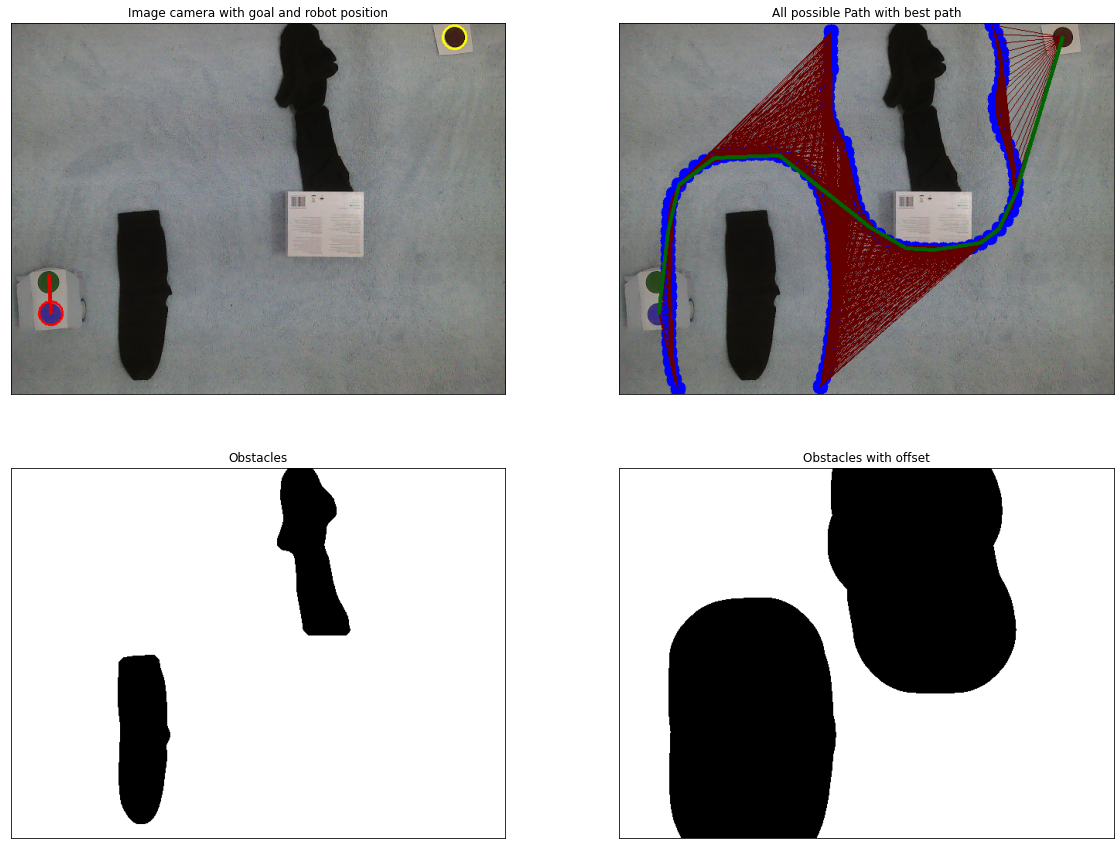

In [22]:
FICHER_TEST = "Atest4.PNG"


# Determine the robot and goal position
if not TEST:
    ret, frame = vid.read() 
else:
    frame = cv2.imread(FICHER_TEST)
    thresholdColor = vision.THRESHOLD_COLOR 


pose = vision.getPose(frame,thresholdColor)
posGoal = vision.getGoal(frame,thresholdColor)


# Determine the postion of contour
(posCorner, imageObstacle, imageObstacleDil) = vision.getCrossingPoint(frame, posGoal)


# Determine all posible way to go from one point to another without crossing obstacles
#without tacking into account the robot position
ppt = vision.getPossiblePath(posCorner + [posGoal], imageObstacle)

# Determine all posible way to go from the robot position to contour points without crossing obstacles
ppbr = vision.getPossiblePathByRobot(posCorner + [posGoal], pose[0], imageObstacle)

# Concatenation of two previous list to have all the possible ways to go from the robot to the goal
pp = ppt+ppbr

# Determine the shortest path to go from the robot to the goal
bestPath = global_nav.dijstra(pose[0], posGoal, pp)


#------------------------DRAW THE FOUND SOLUTION-----------------------------------#

possiblePath = frame.copy()
for pos in posCorner:
    possiblePath = cv2.circle(possiblePath, pos, 10, (0,0,255), -1)
possiblePath = vision.drawPossiblePath(pp, possiblePath)

imgDil_path = imageObstacleDil.copy()
pathObstacleDil = vision.drawPossiblePath(pp, imgDil_path)

bestPathImg = vision.drawBestPath(bestPath, possiblePath)

vision.drawRobotAndGoal(frame, pose, posGoal, True)


fig = plt.figure(figsize = (20, 15))
plt.subplot(221),plt.imshow(frame)
plt.title('Image camera with goal and robot position'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(bestPathImg,cmap = 'gray')
plt.title('All possible Path with best path'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(imageObstacle,cmap = 'gray')
plt.title('Obstacles'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(imageObstacleDil,cmap = 'gray')
plt.title('Obstacles with offset'), plt.xticks([]), plt.yticks([])

## Thymio control loop <a class="anchor" id="Loop"></a>

For this project, the robot have 3 states:

    - Global navigation (state = 1). This is the "normal state" for each iteration, the program recomputes the velocity of each motor for the robot follow to the given path.
    
    - Local navigation (state = 2). In this state, The program uses information from Thymio's prox sensors and "virtual sensors" to detect local and global obstacles and to avoid them. When the robot does not detect obstacles, the program returns in state 1 and computes a new best path.
    
    - Kidnapping (state = 3). In this state, the program detects that the robot has been moved, and try to recompute a new path. If the robot is on an global obstacle it can't do it and remains in kidnapping mode until the robot is on free space. 
    
Those behaviours are shown in the below FSM:

<img src="Images\Rapport_image_FSM.JPG" width="700">


        
        -

In [16]:
#Initialisation 
KIDNAPPING_ALERT_THRESHOLD = 50


road = bestPath[1:] #we do not consider the position of the robot as the first position to reach
current = 0
currentPoint = road[current]

h = 154 # hight of the camera from the ground [cm]

dt = 0.13
vl, vr = 0, 0
y = [0,0]
memAlpha = False
deltaDisplacement = 0 # If too big, it's a possible kidnaping and we recompute dijstra
ratio_pixel2mm=h/69 
x_est=np.array([[pose[0][0]*ratio_pixel2mm],[pose[0][1]*ratio_pixel2mm],[pose[1]],[0]])

P_est=1000*np.ones([4,4])


oldPose = pose[0]
pose_est = pose
state = 1

await node.wait_for_variables({"prox.horizontal", "motor.left.speed","motor.right.speed"})

while(True):
    # start time to compute loop period
    start = time.time()
    
    # get image from de scene and compute robot position
    ret, frame = vid.read() 
    pose = vision.getPose(frame,thresholdColor)
    
    # filtering
    sl = node["motor.left.speed"]
    sr = node["motor.right.speed"] 
    x_est, P_est, pose_est = filtering.extended_kalman_filter(x_est, (vl,vr), P_est, pose, (sl,sr), dt,h) 
    
    # Compute the displacment from last loop and go in kidnapping state if applicable
    deltaDisplacement = distance.euclidean(oldPose,pose_est[0])
    oldPose = pose_est[0]
    
    if (deltaDisplacement > KIDNAPPING_ALERT_THRESHOLD) or state == 3:
        vl, vr = 0, 0
        
        if imageObstacleDil[pose_est[0][1]][pose_est[0][0]] == 255:
            ppbr = vision.getPossiblePathByRobot(posCorner + [posGoal], pose_est[0], imageObstacle)
            pp = ppt+ppbr
            bestPath = global_nav.dijstra(pose_est[0], posGoal, pp)
            road = bestPath[1:]
            current = 0
            currentPoint = road[current]
            state = 1
        else:
            state = 3
    
       
    
      
    # Take meausure from sensor
    prox_horizontal = list(node["prox.horizontal"])
    last_state = state
    state = local_nav.test_state(pose_est,state, prox_horizontal, imageObstacleDil)
    
    #Global navigation
    if state == 1:
        # If last state was local navigation, we compute an new path for the robot
        if (last_state == 2):
            ppbr = vision.getPossiblePathByRobot(posCorner + [posGoal], pose_est[0], imageObstacle)
            pp = ppt+ppbr
            bestPath = global_nav.dijstra(pose_est[0], posGoal, pp)
            road = bestPath[1:]
            current = 0
            currentPoint = road[current]
        
        # If the goal is reach we finish the loop
        if (motion.isPointReach(posGoal, pose_est[0])):
            break
        
        #If current point is reach we determine the next point to reach
        if motion.isPointReach(currentPoint, pose_est[0]):
            current = current+1
            currentPoint = road[current]
         
        # Finally we compute the speed of motor to go toward the next point
        vl, vr, memAlpha = motion.reachPoint(pose_est, currentPoint, memAlpha)
        
     
    # Local navigation
    if state == 2:  
        vl,vr = local_nav.prox(pose_est, prox_horizontal ,imageObstacle)
        
     
    # We set the motor with the speed we calculate
    v = {
    "motor.left.target": [int(vl)],
    "motor.right.target": [int(vr)],
    }
    await node.set_variables(v) 

   
    #Display the video
    vision.drawRobotAndGoal(frame, pose_est)
    vision.drawBestPath(bestPath, frame)    
    points = local_nav.getPoints (pose_est)
    for i in points:
        cv2.circle(frame, i, 5, (50,0,50), -1)
        
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    #compute loop period
    end = time.time()
    dt = round((end-start),4)


# Stop the robot
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
await node.set_variables(v)

time.sleep(3)
# Shut down the videp
cv2.destroyAllWindows()

In [20]:
cv2.destroyAllWindows()
vid.release()


# Conclusion <a class="anchor" id="Conclusion"></a>

In this project we managed to create a robust program that allows a Thymio robot to go from a point A to a point B following an optimized path while taking obstacles into account. It is able to avoid known 2D black obstacles using global vision as well as unexpected 3D obstacles using proximity sensors in local navigation. The global vision processes the pictures taken from a camera positioned above the thymio to detect the position of the objective, the obstacles and the robot itself.
Thanks to filtering it is also able to perform these tasks without the help of the camera for a certain duration. 
To conclude, our project meets our objectives and is robust enough to deal with a variety of unexpected situations; this program could thus be adapted and implemented on a real life tractor as a primitive form of a driverless agricultural vehicle.


# References <a class="anchor" id="References"></a>

[1] M. Ben-Ari and F. Mondada, Elements of robotics. Springer Nature, 2017

[2] Course material of MICRO-452 Basics of mobile robotics, taught by F. Mondada, 2022